In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
from torch.optim import SGD

In [3]:
df = pd.read_csv(".\insurance.csv")
num_samples, num_features = df.drop(["charges"], axis=1).shape
print(num_samples, num_features)
df.head()

1338 6


,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [4]:
print(np.unique(df['region'].values))
df['sex'] = df['sex'].map({'male': 0, 'female': 1})
df['smoker'] = df['smoker'].map({'yes': 1, 'no': 0})
df['region'] = df['region'].map({
    'southwest': 0, 'southeast': 1, 'northwest': 2, 'northeast': 3
})
df.head()

['northeast' 'northwest' 'southeast' 'southwest']


,age,sex,bmi,children,smoker,region,charges
0,19,1,27.900,0,1,0,16884.92400
1,18,0,33.770,1,0,1,1725.55230
2,28,0,33.000,3,0,1,4449.46200
3,33,0,22.705,0,0,2,21984.47061
4,32,0,28.880,0,0,2,3866.85520


In [5]:
X = df.drop(["charges"], axis=1).values
y = df['charges'].values.reshape(-1, 1)
X.shape, y.shape

((1338, 6), (1338, 1))

In [6]:
X

array([[19.  ,  1.  , 27.9 ,  0.  ,  1.  ,  0.  ],
       [18.  ,  0.  , 33.77,  1.  ,  0.  ,  1.  ],
       [28.  ,  0.  , 33.  ,  3.  ,  0.  ,  1.  ],
       ...,
       [18.  ,  1.  , 36.85,  0.  ,  0.  ,  1.  ],
       [21.  ,  1.  , 25.8 ,  0.  ,  0.  ,  0.  ],
       [61.  ,  1.  , 29.07,  0.  ,  1.  ,  2.  ]], shape=(1338, 6))

In [7]:
y

array([[16884.924 ],
       [ 1725.5523],
       [ 4449.462 ],
       ...,
       [ 1629.8335],
       [ 2007.945 ],
       [29141.3603]], shape=(1338, 1))

In [8]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [9]:
X_train

array([[46.   ,  1.   , 19.95 ,  2.   ,  0.   ,  2.   ],
       [47.   ,  1.   , 24.32 ,  0.   ,  0.   ,  3.   ],
       [52.   ,  1.   , 24.86 ,  0.   ,  0.   ,  1.   ],
       ...,
       [58.   ,  0.   , 25.175,  0.   ,  0.   ,  3.   ],
       [37.   ,  1.   , 47.6  ,  2.   ,  1.   ,  0.   ],
       [55.   ,  0.   , 29.9  ,  0.   ,  0.   ,  0.   ]], shape=(1070, 6))

In [10]:
y_train

array([[ 9193.8385 ],
       [ 8534.6718 ],
       [27117.99378],
       ...,
       [11931.12525],
       [46113.511  ],
       [10214.636  ]], shape=(1070, 1))

In [11]:
scaler_X = StandardScaler()
X_train[:, [0, 2]] = scaler_X.fit_transform(X_train[:, [0, 2]])
X_test[:, [0, 2]] = scaler_X.transform(X_test[:, [0, 2]])

In [12]:
X_train

array([[ 0.47222651,  1.        , -1.75652513,  2.        ,  0.        ,
         2.        ],
       [ 0.54331294,  1.        , -1.03308239,  0.        ,  0.        ,
         3.        ],
       [ 0.8987451 ,  1.        , -0.94368672,  0.        ,  0.        ,
         1.        ],
       ...,
       [ 1.3252637 ,  0.        , -0.89153925,  0.        ,  0.        ,
         3.        ],
       [-0.16755139,  1.        ,  2.82086429,  2.        ,  1.        ,
         0.        ],
       [ 1.1120044 ,  0.        , -0.10932713,  0.        ,  0.        ,
         0.        ]], shape=(1070, 6))

In [13]:
scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train)
y_test_scaled = scaler_y.transform(y_test)

In [14]:
y_train

array([[ 9193.8385 ],
       [ 8534.6718 ],
       [27117.99378],
       ...,
       [11931.12525],
       [46113.511  ],
       [10214.636  ]], shape=(1070, 1))

In [15]:
y_train_scaled

array([[-0.3456208 ],
       [-0.40048783],
       [ 1.14633152],
       ...,
       [-0.11777735],
       [ 2.72746075],
       [-0.26065271]], shape=(1070, 1))

In [16]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_scaled, dtype=torch.float32)

In [17]:
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [18]:
model = nn.Linear(num_features, 1)
model

Linear(in_features=6, out_features=1, bias=True)

In [19]:
x_batch, y_batch = next(iter(train_loader))
y_hat = model(x_batch)
y_hat.shape, y_hat

(torch.Size([32, 1]),
 tensor([[1.1117],
         [0.9181],
         [1.1399],
         [0.6490],
         [0.4847],
         [1.9508],
         [1.1809],
         [0.6579],
         [0.5557],
         [2.8346],
         [1.1574],
         [1.2831],
         [1.4465],
         [1.2617],
         [1.5358],
         [0.4488],
         [0.5209],
         [1.9135],
         [1.5094],
         [0.7999],
         [0.4714],
         [1.4249],
         [1.3537],
         [0.6967],
         [2.3943],
         [0.6825],
         [0.8929],
         [1.3583],
         [0.4390],
         [1.2869],
         [1.4201],
         [2.9896]], grad_fn=<AddmmBackward0>))

In [20]:
loss_fn = nn.MSELoss()

In [21]:
optimizer = SGD(model.parameters(), lr=0.01, momentum=0.9)
optimizer

SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    fused: None
    lr: 0.01
    maximize: False
    momentum: 0.9
    nesterov: False
    weight_decay: 0
)

In [22]:
n_epochs = 50
loss_train_hist, loss_valid_hist = [], []
acc_train_hist, acc_valid_hist = [], []

In [23]:
for epoch in range(n_epochs):

  mean_loss_train, mean_loss_valid = 0, 0

  for x_batch, y_batch in train_loader:

    # model
    y_hat = model(x_batch)

    # loss
    loss = loss_fn(y_hat, y_batch)

    # gradient
    loss.backward()

    # update
    optimizer.step()
    optimizer.zero_grad()

    mean_loss_train += loss.item() * len(x_batch)

  mean_loss_train = mean_loss_train / len(train_dataset)
  loss_train_hist.append(mean_loss_train)

  print(
  f"Epoch: {epoch}   "
  f"LossTrain: {mean_loss_train}   "
  )

Epoch: 0   LossTrain: 1.0348287953394595   
Epoch: 1   LossTrain: 0.33525531843443895   
Epoch: 2   LossTrain: 0.27137862736376644   
Epoch: 3   LossTrain: 0.2737416778490922   
Epoch: 4   LossTrain: 0.26994899032271913   
Epoch: 5   LossTrain: 0.272131087011266   
Epoch: 6   LossTrain: 0.26450050322808955   
Epoch: 7   LossTrain: 0.26583667071623224   
Epoch: 8   LossTrain: 0.2625991669770713   
Epoch: 9   LossTrain: 0.2648502791039298   
Epoch: 10   LossTrain: 0.2684526661567599   
Epoch: 11   LossTrain: 0.26869113608219913   
Epoch: 12   LossTrain: 0.27520422400715194   
Epoch: 13   LossTrain: 0.28765534268361387   
Epoch: 14   LossTrain: 0.265799096393808   
Epoch: 15   LossTrain: 0.2643964831099332   
Epoch: 16   LossTrain: 0.26602779665840004   
Epoch: 17   LossTrain: 0.26481921497349425   
Epoch: 18   LossTrain: 0.26769376264832845   
Epoch: 19   LossTrain: 0.274613716418498   
Epoch: 20   LossTrain: 0.26949141955821315   
Epoch: 21   LossTrain: 0.2719924108447316   
Epoch: 22  

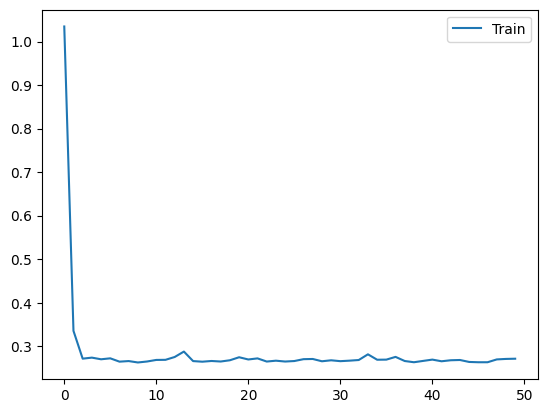

In [24]:
plt.plot(torch.arange(n_epochs), loss_train_hist)
plt.legend(["Train"]);

In [25]:
with torch.no_grad():
  for x_batch, y_batch in test_loader:
    y_hat = model(x_batch)
    error = nn.functional.l1_loss(y_hat, y_batch)
    print(error)


tensor(0.3408)
tensor(0.3264)
tensor(0.3456)
tensor(0.3731)
tensor(0.3652)
tensor(0.3794)
tensor(0.4069)
tensor(0.3520)
tensor(0.3991)
